In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

## DRR Generation

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

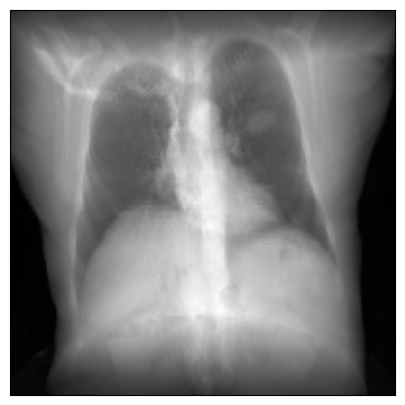

In [ ]:
#| cuda
# Read in the volume and get the isocenter
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=300.0,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,  # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [ ]:
# |cuda
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

33.3 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can also visualize the 3D geometry of this projection:

In [ ]:
import pyvista

from diffdrr.visualization import drr_to_mesh, img_to_mesh

In [ ]:
pyvista.start_xvfb()

In [ ]:
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera)
plotter.add_mesh(detector, texture=texture)
plotter.add_axes()
plotter.add_bounding_box()
plotter.show(jupyter_backend="static")

Computing Contour: 100%|███████████████████████████████████████████████████████████████████████████████[00:01<00:00]
Finding and Labeling Connected Bodies/Volumes.: 100%|██████████████████████████████████████████████████[00:01<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|███████████████████████████████████████████████████████████[00:02<00:00]
Decimating Mesh: 100%|█████████████████████████████████████████████████████████████████████████████████[00:03<00:00]
Filling Holes: 100%|███████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Cleaning: 100%|████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]


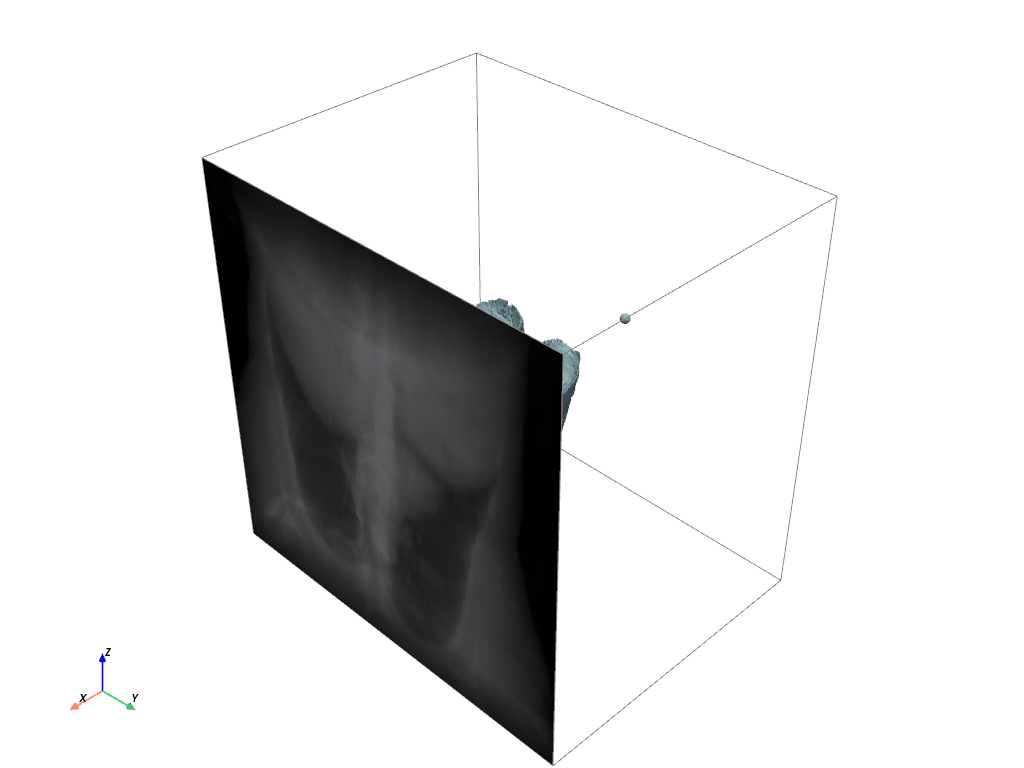

In [ ]:
ct = drr_to_mesh(drr, verbose=True)
camera, detector, texture = img_to_mesh(
    drr,
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
)

plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera)
plotter.add_mesh(detector, texture=texture)
plotter.add_axes()
plotter.add_bounding_box()
plotter.show(jupyter_backend="static")

### Sparse rendering

You can also render random sparse subsets of the pixels in a DRR.

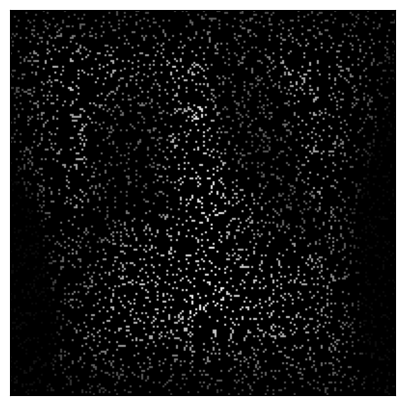

In [ ]:
# |cuda
# Make the DRR with 10% of the pixels
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,  # Map rendered pixels back to their location in true space,
    # Useful for plotting, but can be disabled if using MSE as a loss function
).to(device)

# Make the DRR
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

In [ ]:
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

6.18 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Batched DRR synthesis

The tensors for `rotations` are expected to be of the size `[batch_size, c]`, where `c` is the number of components needed to represent the rotation (`3, 4, 6, 10`).
The tensors for `translations` are expected to be of the size `[batch_size, 3]`.

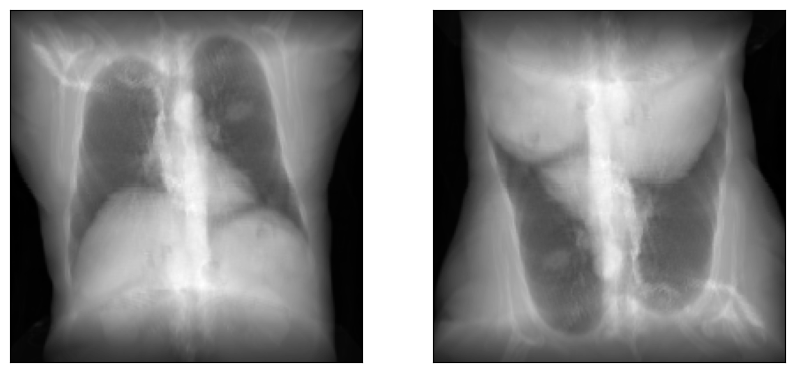

In [ ]:
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
).to(device)

rotations = torch.tensor(
    [[torch.pi, 0.0, torch.pi / 2], [torch.pi, 0.0, -torch.pi / 2]], device=device
)
translations = torch.tensor([[bx, by, bz], [bx, by, bz]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

## Increasing DRR contrast

CT scans are easily segmented using Hounsfield units. We can use this to identify which voxels are air, soft tissue, or bone. By up or downweighting voxels corresponding to bones, we can change the contrast of generated DRRs.

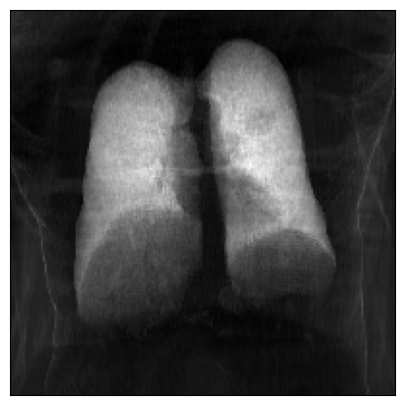

In [ ]:
# Completely downweight bones in CT (i.e., only soft tissue)
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
).to(device)

rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)

img = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
    bone_attenuation_multiplier=0.0,
)
plot_drr(img, ticks=False)
plt.show()

## Simulating parallel-beam DRRs

By default, `DiffDRR` simulates cone-beam X-rays (i.e., a perspective projection).
We can simulate parallel-beam X-ray by approximating an orthographic projection.
We achieve this by moving the camera source arbitrarily far away from the detector plane.
This works because a perspective projection approaches orthographic projection as the focal length approaches infinity.

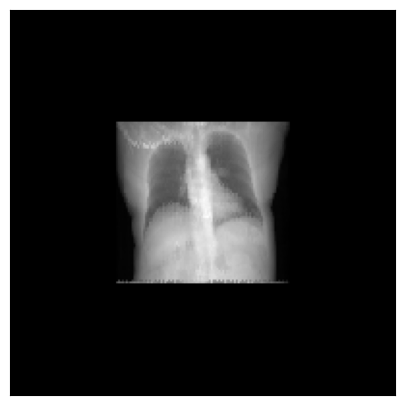

In [ ]:
# Completely downweight bones in CT (i.e., only soft tissue)
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
    mode="orthographic",  # default is "perspective"
).to(device)

rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)

img = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
)
plot_drr(img, ticks=False)
plt.show()

Computing Contour: 100%|███████████████████████████████████████████████████████████████████████████████[00:01<00:00]
Finding and Labeling Connected Bodies/Volumes.: 100%|██████████████████████████████████████████████████[00:01<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|███████████████████████████████████████████████████████████[00:02<00:00]
Decimating Mesh: 100%|█████████████████████████████████████████████████████████████████████████████████[00:03<00:00]
Filling Holes: 100%|███████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Cleaning: 100%|████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]


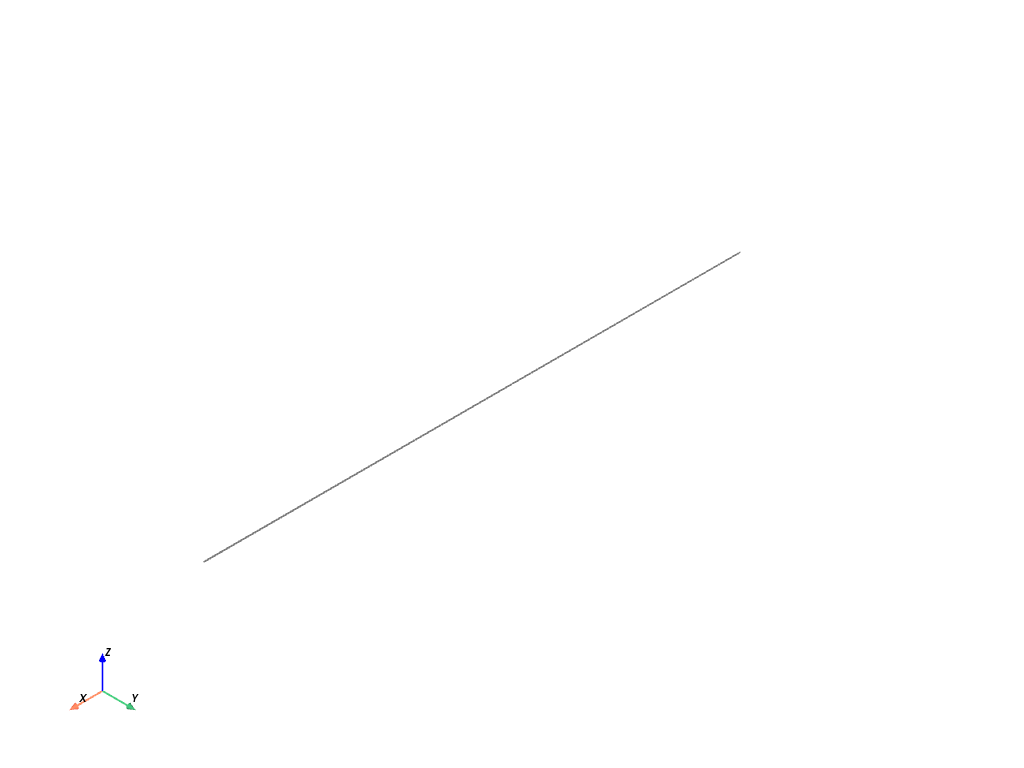

In [ ]:
ct = drr_to_mesh(drr, verbose=True)
camera, detector, texture = img_to_mesh(
    drr,
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
)

plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera)
plotter.add_mesh(detector, texture=texture)
plotter.add_axes()
plotter.add_bounding_box()
plotter.show(jupyter_backend="static")